# Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
# disable tensorflow log level infos
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # show only errors

import sys
import pandas as pd

if '../../../../notebooks/' not in sys.path:
    sys.path.append('../../../../notebooks/')
if 'src' not in sys.path:
    sys.path.insert(0, 'src')

import utils.constants as cts

from data_loaders.data_loader import DLName
from gt_loaders.gt_names import GTName
from exp_runner import ExperimentRunner
from base.model_evaluator import DataSource, DataPredSelection
from base.base_models import BaseModel
from base.optimizers import Optimizer
from base.model_creator import MTLApproach, NAS_MTLApproach

 ==> Restrict GPU memory growth: True


# Start Network runner

In [3]:
kwargs = { 
    'use_neptune': True,
    'exp_params' : {
        'name': 'neural_arch_search',
        'description': 'Making NAS with APPROACH_1 (random) and training best architecture for 50 epochs to evaluate on test set',
        'tags': ['ground truths', 'nas', 'nas_approach_1'],
        'src_files': ["src/**/*.py"]
    },
    'properties': {
        'approach': NAS_MTLApproach.APPROACH_1,
        'reqs': list(cts.ICAO_REQ),
        'aligned': False,
        'use_gt_data': True,
        'gt_names': {
            'train_validation': [],
            'test': [],
            'train_validation_test': [GTName.FVC]
        },
        'balance_input_data': False,
        'train_model': True,
        'save_trained_model': True,
        'exec_nas': False,
        'orig_model_experiment_id': 'ICAO-265',
        'sample_training_data': False,
        'sample_prop': 1.0
    },
    'net_train_params': {
        'base_model': BaseModel.VGG16,
        'batch_size': 32,
        'n_epochs': 50,
        'early_stopping': 99,
        'learning_rate': 1e-3,
        'optimizer': Optimizer.ADAMAX,
        'dropout': 0.3
    },
    'nas_params': {
        'max_blocks_per_branch': 5,
        'n_epochs': 5,
        'n_trials': 30
    }
}

runner = ExperimentRunner(**kwargs)

-------------------- Init ExperimentRunner -------------------
---------------------------
Parent Process ID: 9385
Process ID: 10564
---------------------------
-----
Use Neptune:  True
-----
-------------------
Args: 
{'exp_params': {'description': 'Making NAS with APPROACH_1 (random) and '
                               'training best architecture for 50 epochs to '
                               'evaluate on test set',
                'name': 'neural_arch_search',
                'src_files': ['src/**/*.py'],
                'tags': ['ground truths', 'nas', 'nas_approach_1']},
 'nas_params': {'max_blocks_per_branch': 5, 'n_epochs': 5, 'n_trials': 30},
 'net_train_params': {'base_model': <BaseModel.VGG16: {'target_size': (224, 224), 'prep_function': <function preprocess_input at 0x7f44104224c0>}>,
                      'batch_size': 32,
                      'dropout': 0.3,
                      'early_stopping': 99,
                      'learning_rate': 0.001,
                     

# Load Data

In [4]:
runner.load_training_data()

-------------------- load training data -------------------
Loading data
Loading GT FVC - TRAIN split...
..Ignoring 0 empty label values
Input data.shape: (4928, 26)
Loading GT FVC - VALIDATION split...
..Ignoring 0 empty label values
Input data.shape: (547, 26)
Loading GT FVC - TEST split...
..Ignoring 0 empty label values
Input data.shape: (288, 26)
Data loaded


# Data Generators

In [5]:
runner.setup_data_generators()

-------------------- setup data generators -------------------
Starting data generators
Found 4928 validated image filenames.
Found 547 validated image filenames.
Found 288 validated image filenames.
TOTAL: 5763

Logging class indices
 .. MTL model not logging class indices!

Logging class labels
 COMPLIANT label: 1
 NON_COMPLIANT label: 0
 DUMMY label: -1
 DUMMY_CLS label: 2
 NO_ANSWER label: -99


# Setup Experiment

In [6]:
runner.setup_experiment()

-------------------- create experiment -------------------
Setup neptune properties and parameters
Properties and parameters setup done!


# Labels Distribution

In [7]:
%%capture
runner.summary_labels_dist()

# Neural Architecture Search

In [8]:
runner.run_neural_architeture_search()

-------------------- run neural architecture search -------------------
Not executing neural architecture search
 ..Experiment ID: ICAO-265
 ..Downloading data from previous experiment
https://ui.neptune.ai/guilhermemg/icao-nets-training-2/e/ICAO-265
  ...fetching data from previous trials
  ...fetching data from best trial
 ..Data uploaded to current experiment


# Create Model

In [9]:
best_config = {'n_denses_0': 5, 'n_denses_1': 1, 'n_denses_2': 4, 'n_denses_3': 5}
runner.create_model(best_config)

-------------------- create model -------------------
Creating model...
Model created


# Visualize Model

-------------------- vizualize model -------------------


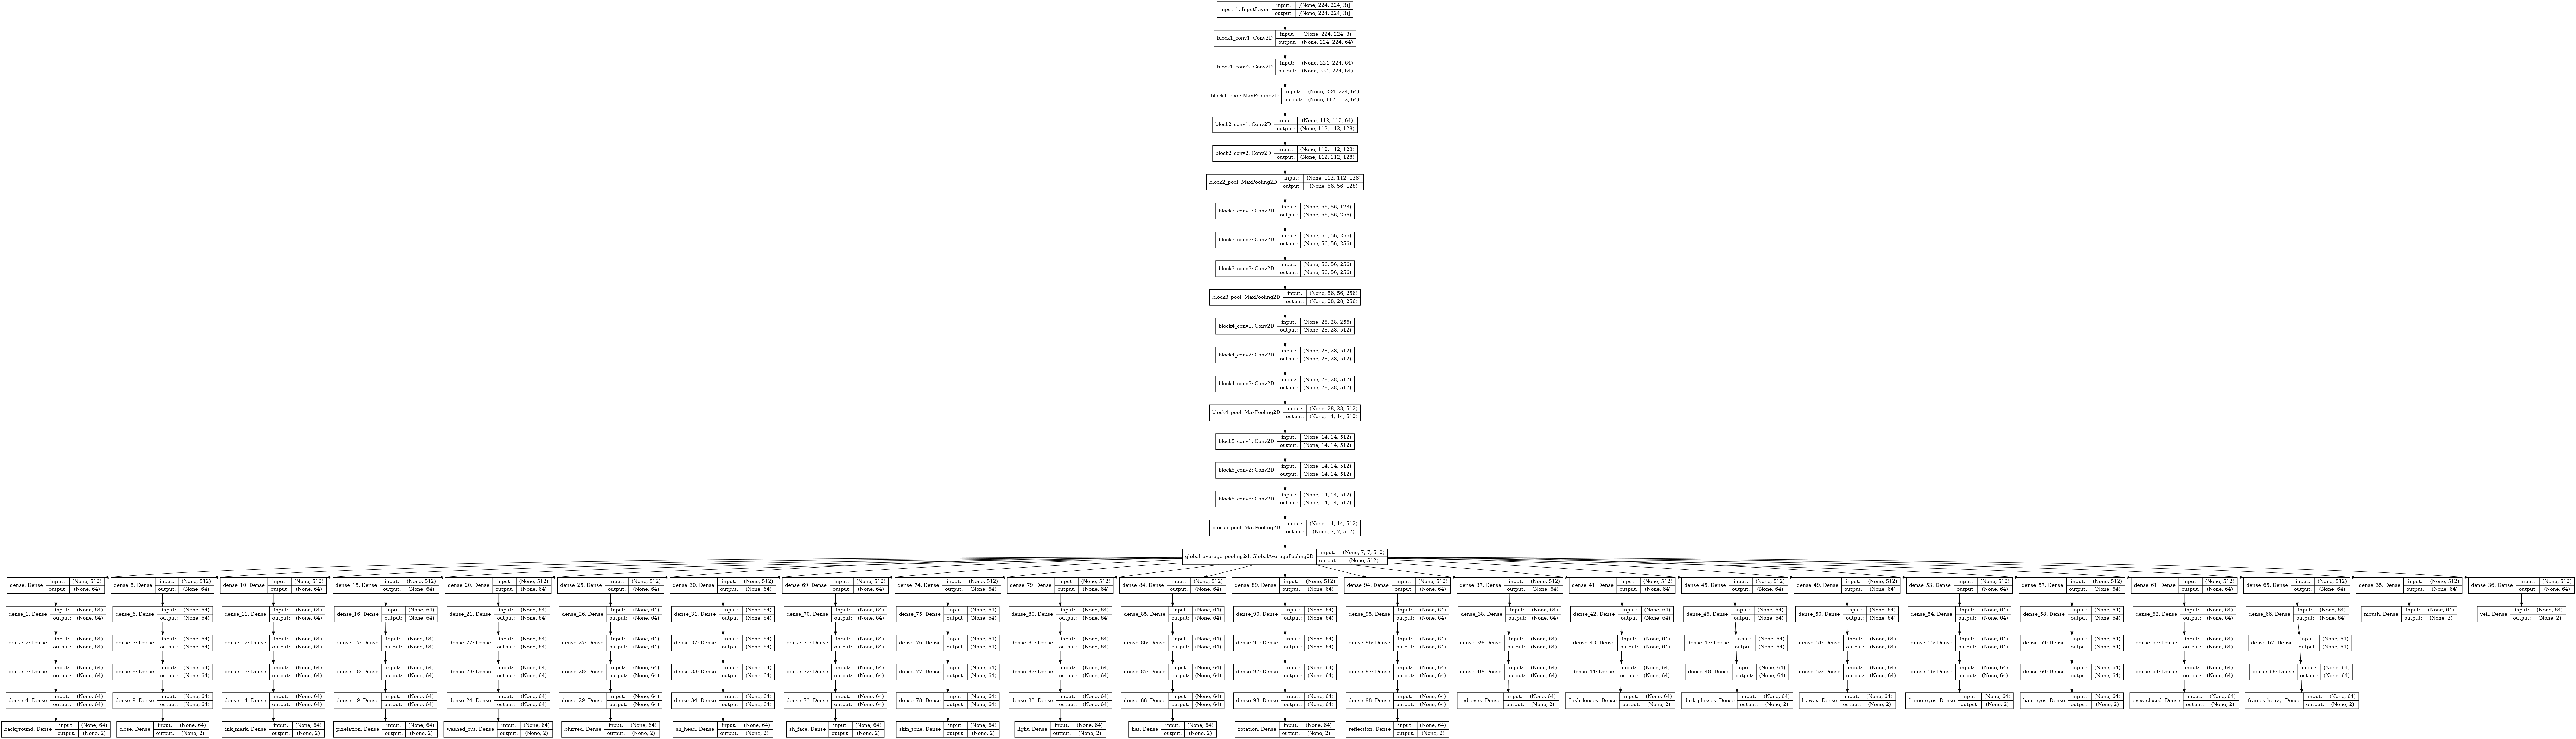

In [10]:
runner.visualize_model(outfile_path=f"figs/nas/nas_model_approach_1.png")

In [11]:
%%capture
runner.model_summary()

# Training Model

In [12]:
runner.train_model()

-------------------- train model -------------------
Training VGG16 network
 .. Not fine tuning base model...
  .. Total params: 15,788,974
  .. Trainable params: 1,074,286
  .. Non-trainable params: 14,714,688
Epoch 1/50


154/154 [==============================] - 437s 3s/step - loss: 1.1595 - background_loss: 0.7590 - close_loss: 0.5595 - ink_mark_loss: 0.6443 - pixelation_loss: 0.5924 - washed_out_loss: 0.1022 - blurred_loss: 0.5042 - sh_head_loss: 0.3871 - mouth_loss: 0.1187 - veil_loss: 0.7571 - red_eyes_loss: 0.6865 - flash_lenses_loss: 0.3101 - dark_glasses_loss: 0.7734 - l_away_loss: 0.3579 - frame_eyes_loss: 0.8283 - hair_eyes_loss: 0.6898 - eyes_closed_loss: 0.3872 - frames_heavy_loss: 0.1965 - sh_face_loss: 0.7062 - skin_tone_loss: 0.0586 - light_loss: 0.2882 - hat_loss: 0.5149 - rotation_loss: 0.8320 - reflection_loss: 0.5407 - background_accuracy: 0.7305 - close_accuracy: 0.7478 - ink_mark_accuracy: 0.6719 - pixelation_accuracy: 0.7886 - washed_out_accuracy: 0.9846 - blurred_accuracy: 0.8573 - sh_head_accuracy: 0.8841 - mouth_accuracy: 0.9880 - veil_accuracy: 0.6879 - red_eyes_accuracy: 0.7902 - flash_lenses_accuracy: 0.9136 - dark_glasses_accuracy: 0.5215 - l_away_accuracy: 0.9087 - frame_e

# Plots

-------------------- draw training history -------------------


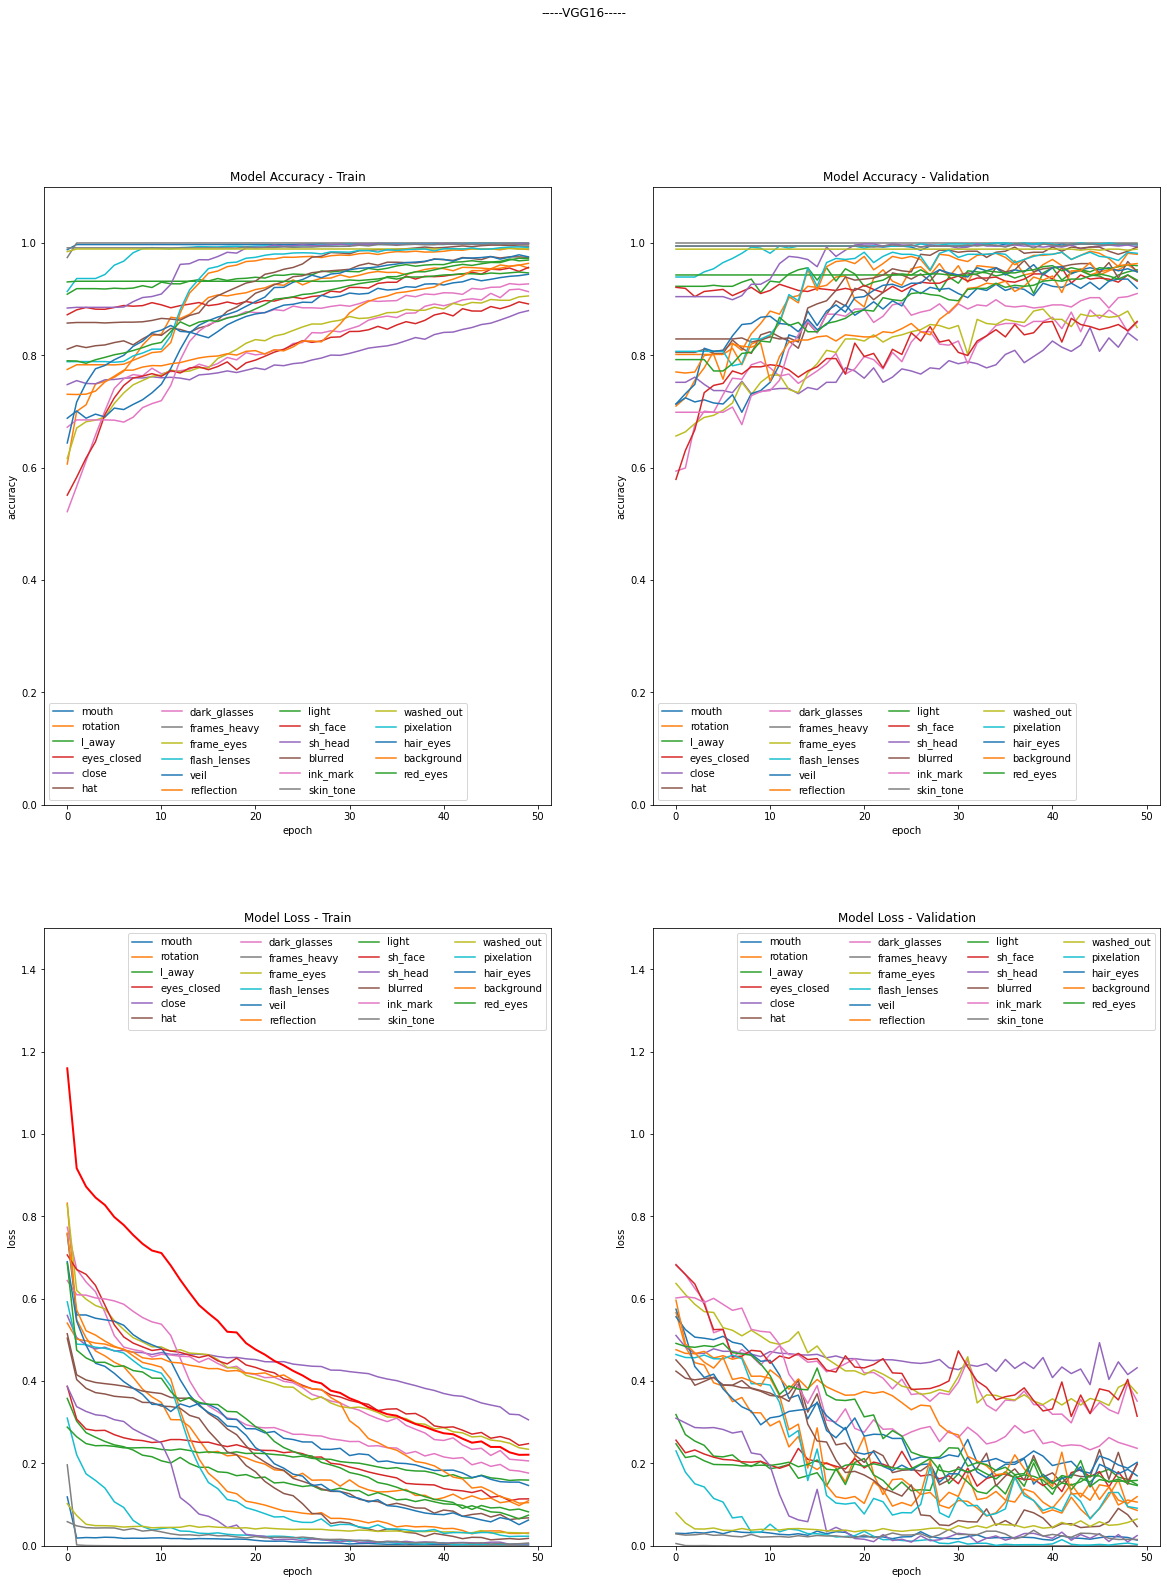

In [13]:
runner.draw_training_history()

# Load Best Model

In [14]:
runner.load_best_model()

-------------------- load best model -------------------
..Loading best model
..Checkpoint weights loaded


# Saving Trained Model

In [15]:
runner.save_model()

-------------------- save model -------------------
Saving model
INFO:tensorflow:Assets written to: prev_trained_models/multi_task/fvc_not_aligned/multi_reqs/ICAO-265/assets
..Model saved
...Model path: prev_trained_models/multi_task/fvc_not_aligned/multi_reqs/ICAO-265
Saving model to neptune
 ..Uploading file trained_model.zip
Model saved into Neptune
Saving process finished


# Test Trained Model

## Validation Split

Testing Trained Model
Predicting labels....
18/18 [==============================] - 33s 2s/step
Prediction finished!
Requisite: MOUTH


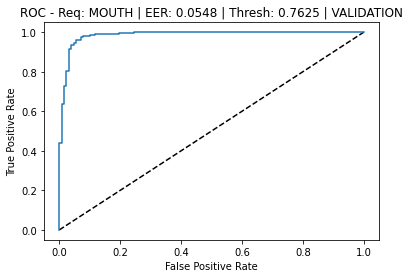

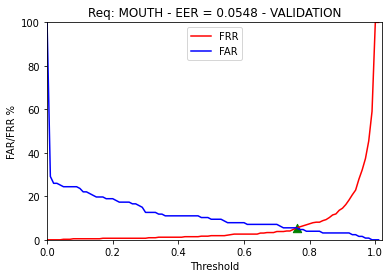

Requisite: MOUTH - EER_interp: 5.48% - Best Threshold: 0.7624928551060812
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.84      0.95      0.89       127
    COMPLIANT       0.99      0.95      0.96       420

     accuracy                           0.95       547
    macro avg       0.91      0.95      0.93       547
 weighted avg       0.95      0.95      0.95       547

Confusion matrix ----------------------------------------
FAR: 4.72% | FRR: 5.48% | EER_mean: 5.1% | TP: 397 | TN: 121 | FP: 6 | FN: 23
Accuracy ------------------------------------------------
Model Accuracy: 94.69999999999999%
---------------------------------------------------------
Requisite: ROTATION


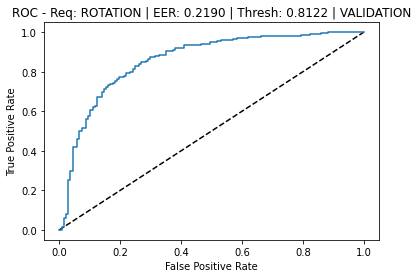

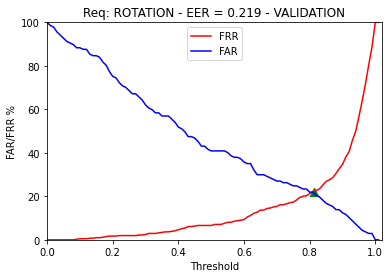

Requisite: ROTATION - EER_interp: 21.9% - Best Threshold: 0.8121821880342214
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.54      0.78      0.64       137
    COMPLIANT       0.91      0.78      0.84       410

     accuracy                           0.78       547
    macro avg       0.73      0.78      0.74       547
 weighted avg       0.82      0.78      0.79       547

Confusion matrix ----------------------------------------
FAR: 21.9% | FRR: 22.2% | EER_mean: 22.05% | TP: 319 | TN: 107 | FP: 30 | FN: 91
Accuracy ------------------------------------------------
Model Accuracy: 77.88000000000001%
---------------------------------------------------------
Requisite: L_AWAY


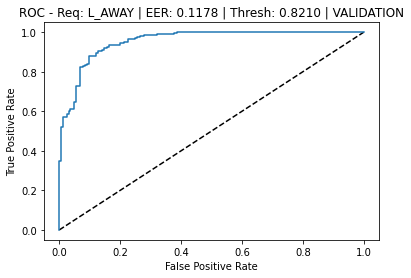

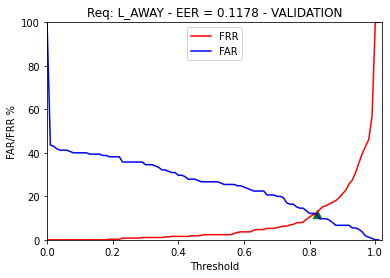

Requisite: L_AWAY - EER_interp: 11.78% - Best Threshold: 0.8209593389670886
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.76      0.88      0.82       165
    COMPLIANT       0.95      0.88      0.91       382

     accuracy                           0.88       547
    macro avg       0.86      0.88      0.87       547
 weighted avg       0.89      0.88      0.89       547

Confusion matrix ----------------------------------------
FAR: 11.52% | FRR: 11.78% | EER_mean: 11.65% | TP: 337 | TN: 146 | FP: 19 | FN: 45
Accuracy ------------------------------------------------
Model Accuracy: 88.3%
---------------------------------------------------------
Requisite: EYES_CLOSED


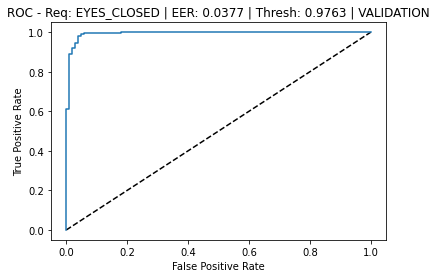

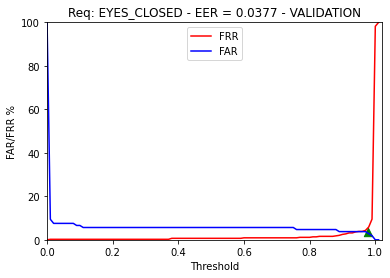

Requisite: EYES_CLOSED - EER_interp: 3.7699999999999996% - Best Threshold: 0.9762849211693625
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.81      0.96      0.88       106
    COMPLIANT       0.99      0.95      0.97       441

     accuracy                           0.95       547
    macro avg       0.90      0.95      0.92       547
 weighted avg       0.96      0.95      0.95       547

Confusion matrix ----------------------------------------
FAR: 3.7699999999999996% | FRR: 5.4399999999999995% | EER_mean: 4.6% | TP: 417 | TN: 102 | FP: 4 | FN: 24
Accuracy ------------------------------------------------
Model Accuracy: 94.88%
---------------------------------------------------------
Requisite: CLOSE


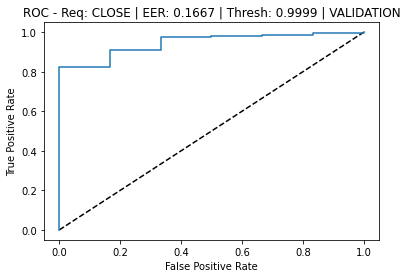

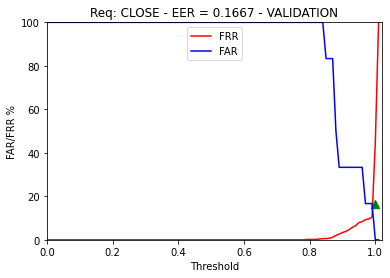

Requisite: CLOSE - EER_interp: 16.669999999999998% - Best Threshold: 0.9999029636383057
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.05      0.83      0.09         6
    COMPLIANT       1.00      0.82      0.90       541

     accuracy                           0.82       547
    macro avg       0.52      0.83      0.50       547
 weighted avg       0.99      0.82      0.89       547

Confusion matrix ----------------------------------------
FAR: 16.669999999999998% | FRR: 17.560000000000002% | EER_mean: 17.119999999999997% | TP: 446 | TN: 5 | FP: 1 | FN: 95
Accuracy ------------------------------------------------
Model Accuracy: 82.45%
---------------------------------------------------------
Requisite: HAT


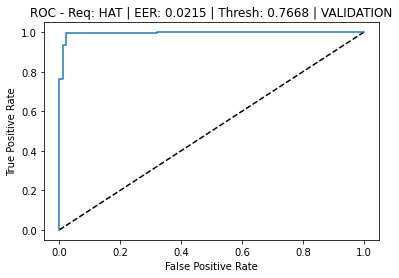

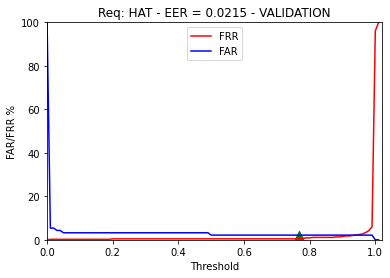

Requisite: HAT - EER_interp: 2.15% - Best Threshold: 0.7667989730806137
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.98      0.98      0.98        93
    COMPLIANT       1.00      1.00      1.00       454

     accuracy                           0.99       547
    macro avg       0.99      0.99      0.99       547
 weighted avg       0.99      0.99      0.99       547

Confusion matrix ----------------------------------------
FAR: 2.15% | FRR: 0.44% | EER_mean: 1.3% | TP: 452 | TN: 91 | FP: 2 | FN: 2
Accuracy ------------------------------------------------
Model Accuracy: 99.27%
---------------------------------------------------------
Requisite: DARK_GLASSES


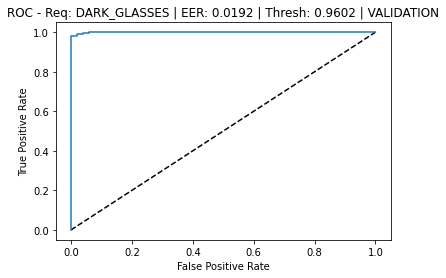

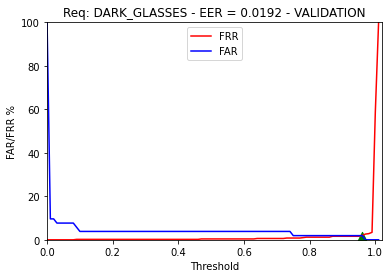

Requisite: DARK_GLASSES - EER_interp: 1.92% - Best Threshold: 0.9601706862450778
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.84      0.98      0.90        52
    COMPLIANT       1.00      0.98      0.99       495

     accuracy                           0.98       547
    macro avg       0.92      0.98      0.95       547
 weighted avg       0.98      0.98      0.98       547

Confusion matrix ----------------------------------------
FAR: 1.92% | FRR: 2.02% | EER_mean: 1.97% | TP: 485 | TN: 51 | FP: 1 | FN: 10
Accuracy ------------------------------------------------
Model Accuracy: 97.99%
---------------------------------------------------------
Requisite: FRAMES_HEAVY


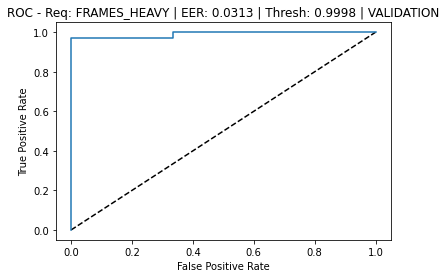

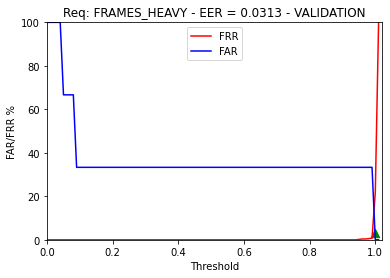

Requisite: FRAMES_HEAVY - EER_interp: 3.1300000000000003% - Best Threshold: 0.9998007528483868
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.15      1.00      0.26         3
    COMPLIANT       1.00      0.97      0.98       544

     accuracy                           0.97       547
    macro avg       0.57      0.98      0.62       547
 weighted avg       1.00      0.97      0.98       547

Confusion matrix ----------------------------------------
FAR: 0.0% | FRR: 3.1199999999999997% | EER_mean: 1.5599999999999998% | TP: 527 | TN: 3 | FP: 0 | FN: 17
Accuracy ------------------------------------------------
Model Accuracy: 96.89%
---------------------------------------------------------
Requisite: FRAME_EYES


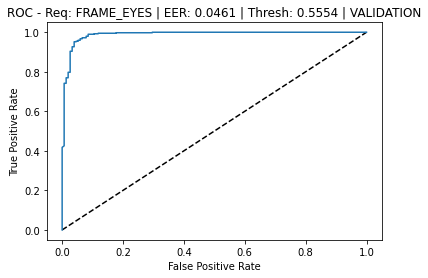

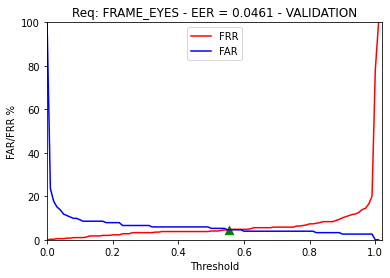

Requisite: FRAME_EYES - EER_interp: 4.61% - Best Threshold: 0.5553862452506373
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.89      0.95      0.92       152
    COMPLIANT       0.98      0.95      0.97       395

     accuracy                           0.95       547
    macro avg       0.94      0.95      0.94       547
 weighted avg       0.96      0.95      0.95       547

Confusion matrix ----------------------------------------
FAR: 4.61% | FRR: 4.5600000000000005% | EER_mean: 4.58% | TP: 377 | TN: 145 | FP: 7 | FN: 18
Accuracy ------------------------------------------------
Model Accuracy: 95.43%
---------------------------------------------------------
Requisite: FLASH_LENSES


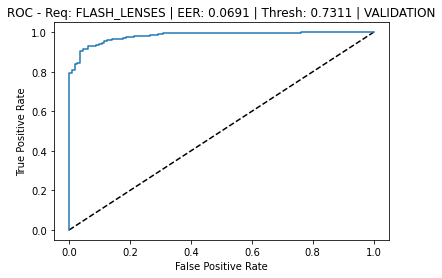

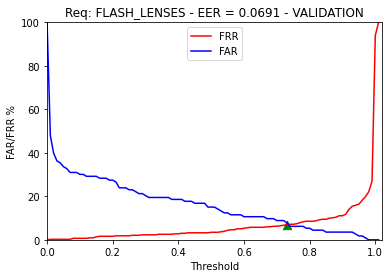

Requisite: FLASH_LENSES - EER_interp: 6.909999999999999% - Best Threshold: 0.731141251536192
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.78      0.92      0.84       113
    COMPLIANT       0.98      0.93      0.95       434

     accuracy                           0.93       547
    macro avg       0.88      0.93      0.90       547
 weighted avg       0.94      0.93      0.93       547

Confusion matrix ----------------------------------------
FAR: 7.960000000000001% | FRR: 6.909999999999999% | EER_mean: 7.4399999999999995% | TP: 404 | TN: 104 | FP: 9 | FN: 30
Accuracy ------------------------------------------------
Model Accuracy: 92.86999999999999%
---------------------------------------------------------
Requisite: VEIL


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


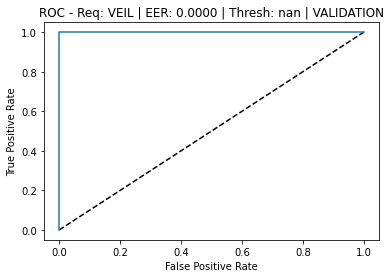

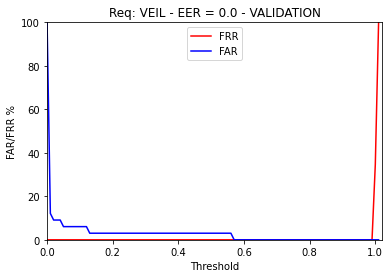

Requisite: VEIL - EER_interp: 0.0% - Best Threshold: nan
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.00      0.00      0.00        33
    COMPLIANT       0.94      1.00      0.97       514

     accuracy                           0.94       547
    macro avg       0.47      0.50      0.48       547
 weighted avg       0.88      0.94      0.91       547

Confusion matrix ----------------------------------------
FAR: 100.0% | FRR: 0.0% | EER_mean: 50.0% | TP: 514 | TN: 0 | FP: 33 | FN: 0
Accuracy ------------------------------------------------
Model Accuracy: 93.97%
---------------------------------------------------------
Requisite: REFLECTION


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


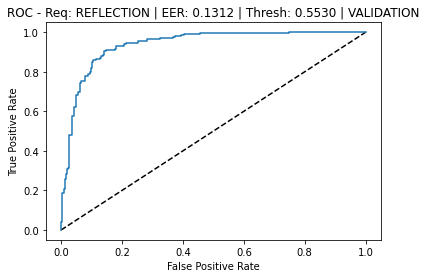

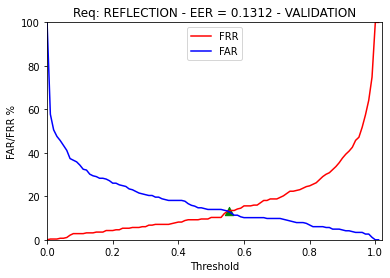

Requisite: REFLECTION - EER_interp: 13.120000000000001% - Best Threshold: 0.5529942723876196
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.86      0.87      0.87       265
    COMPLIANT       0.88      0.87      0.87       282

     accuracy                           0.87       547
    macro avg       0.87      0.87      0.87       547
 weighted avg       0.87      0.87      0.87       547

Confusion matrix ----------------------------------------
FAR: 12.83% | FRR: 13.120000000000001% | EER_mean: 12.98% | TP: 245 | TN: 231 | FP: 34 | FN: 37
Accuracy ------------------------------------------------
Model Accuracy: 87.02%
---------------------------------------------------------
Requisite: LIGHT


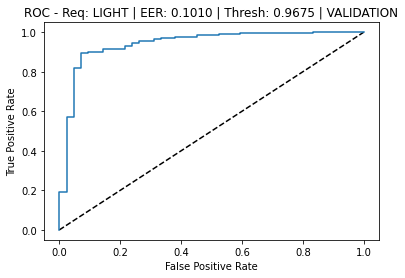

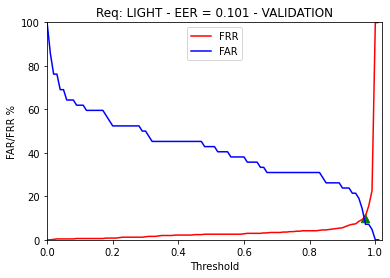

Requisite: LIGHT - EER_interp: 10.100000000000001% - Best Threshold: 0.967484162821628
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.42      0.88      0.57        42
    COMPLIANT       0.99      0.90      0.94       505

     accuracy                           0.90       547
    macro avg       0.70      0.89      0.76       547
 weighted avg       0.95      0.90      0.91       547

Confusion matrix ----------------------------------------
FAR: 11.899999999999999% | FRR: 10.100000000000001% | EER_mean: 11.0% | TP: 454 | TN: 37 | FP: 5 | FN: 51
Accuracy ------------------------------------------------
Model Accuracy: 89.75999999999999%
---------------------------------------------------------
Requisite: SH_FACE


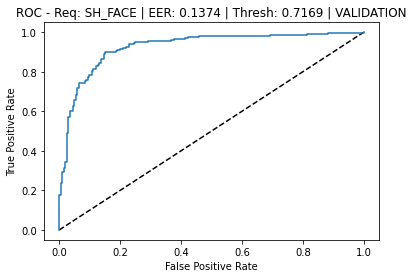

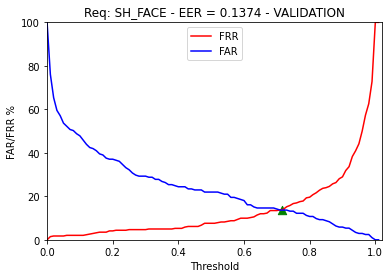

Requisite: SH_FACE - EER_interp: 13.74% - Best Threshold: 0.716938839669598
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.79      0.86      0.83       205
    COMPLIANT       0.91      0.86      0.89       342

     accuracy                           0.86       547
    macro avg       0.85      0.86      0.86       547
 weighted avg       0.87      0.86      0.86       547

Confusion matrix ----------------------------------------
FAR: 13.66% | FRR: 13.74% | EER_mean: 13.700000000000001% | TP: 295 | TN: 177 | FP: 28 | FN: 47
Accuracy ------------------------------------------------
Model Accuracy: 86.29%
---------------------------------------------------------
Requisite: SH_HEAD


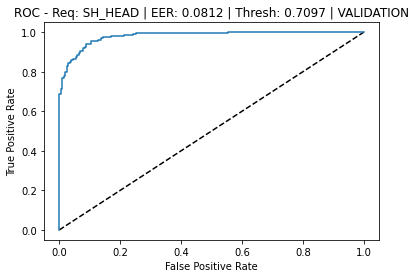

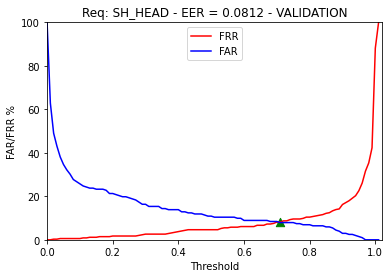

Requisite: SH_HEAD - EER_interp: 8.12% - Best Threshold: 0.7097386764444196
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.87      0.92      0.89       202
    COMPLIANT       0.95      0.92      0.94       345

     accuracy                           0.92       547
    macro avg       0.91      0.92      0.91       547
 weighted avg       0.92      0.92      0.92       547

Confusion matrix ----------------------------------------
FAR: 7.920000000000001% | FRR: 8.12% | EER_mean: 8.02% | TP: 317 | TN: 186 | FP: 16 | FN: 28
Accuracy ------------------------------------------------
Model Accuracy: 91.96%
---------------------------------------------------------
Requisite: BLURRED


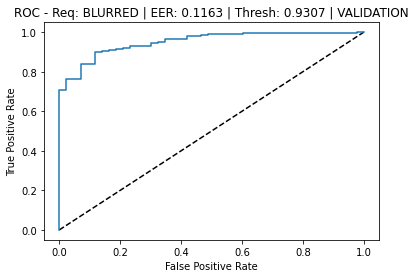

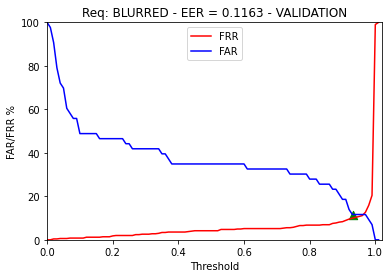

Requisite: BLURRED - EER_interp: 11.63% - Best Threshold: 0.9306844472883852
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.43      0.88      0.58        43
    COMPLIANT       0.99      0.90      0.94       504

     accuracy                           0.90       547
    macro avg       0.71      0.89      0.76       547
 weighted avg       0.95      0.90      0.91       547

Confusion matrix ----------------------------------------
FAR: 11.63% | FRR: 9.92% | EER_mean: 10.780000000000001% | TP: 454 | TN: 38 | FP: 5 | FN: 50
Accuracy ------------------------------------------------
Model Accuracy: 89.95%
---------------------------------------------------------
Requisite: SKIN_TONE


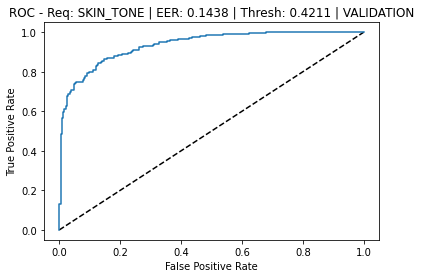

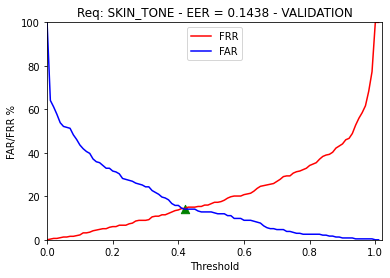

Requisite: SKIN_TONE - EER_interp: 14.38% - Best Threshold: 0.4211469213612165
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.82      0.86      0.84       234
    COMPLIANT       0.89      0.86      0.87       313

     accuracy                           0.86       547
    macro avg       0.85      0.86      0.86       547
 weighted avg       0.86      0.86      0.86       547

Confusion matrix ----------------------------------------
FAR: 14.099999999999998% | FRR: 14.38% | EER_mean: 14.24% | TP: 268 | TN: 201 | FP: 33 | FN: 45
Accuracy ------------------------------------------------
Model Accuracy: 85.74000000000001%
---------------------------------------------------------
Requisite: WASHED_OUT


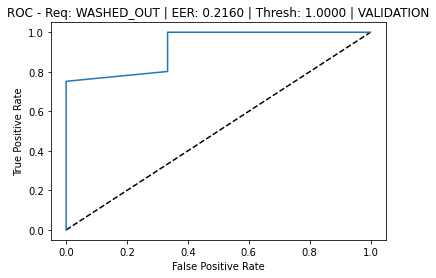

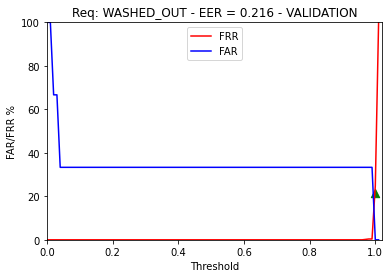

Requisite: WASHED_OUT - EER_interp: 21.6% - Best Threshold: 0.9999999227523804
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.02      1.00      0.04         3
    COMPLIANT       1.00      0.75      0.86       544

     accuracy                           0.75       547
    macro avg       0.51      0.88      0.45       547
 weighted avg       0.99      0.75      0.85       547

Confusion matrix ----------------------------------------
FAR: 0.0% | FRR: 24.82% | EER_mean: 12.41% | TP: 409 | TN: 3 | FP: 0 | FN: 135
Accuracy ------------------------------------------------
Model Accuracy: 75.32%
---------------------------------------------------------
Requisite: PIXELATION


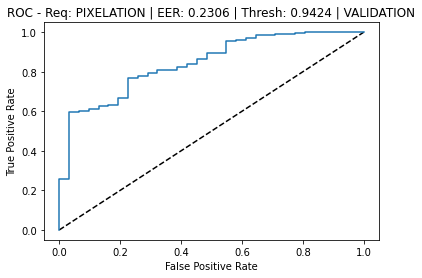

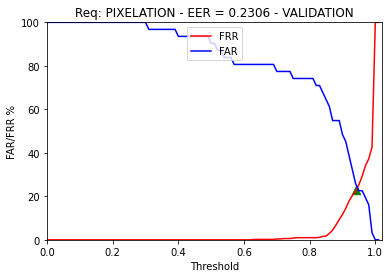

Requisite: PIXELATION - EER_interp: 23.06% - Best Threshold: 0.9423702687256096
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.17      0.77      0.28        31
    COMPLIANT       0.98      0.77      0.86       516

     accuracy                           0.77       547
    macro avg       0.58      0.77      0.57       547
 weighted avg       0.94      0.77      0.83       547

Confusion matrix ----------------------------------------
FAR: 22.58% | FRR: 23.06% | EER_mean: 22.82% | TP: 397 | TN: 24 | FP: 7 | FN: 119
Accuracy ------------------------------------------------
Model Accuracy: 76.97%
---------------------------------------------------------
Requisite: HAIR_EYES


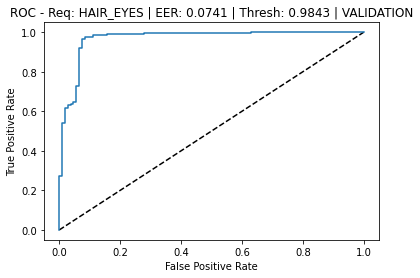

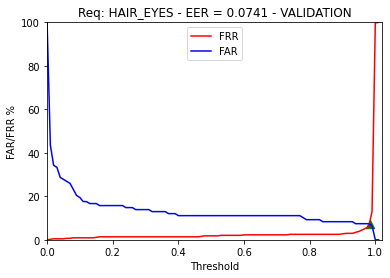

Requisite: HAIR_EYES - EER_interp: 7.41% - Best Threshold: 0.9843149781227218
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.74      0.93      0.82       108
    COMPLIANT       0.98      0.92      0.95       439

     accuracy                           0.92       547
    macro avg       0.86      0.92      0.89       547
 weighted avg       0.93      0.92      0.92       547

Confusion matrix ----------------------------------------
FAR: 7.41% | FRR: 7.969999999999999% | EER_mean: 7.6899999999999995% | TP: 404 | TN: 100 | FP: 8 | FN: 35
Accuracy ------------------------------------------------
Model Accuracy: 92.14%
---------------------------------------------------------
Requisite: BACKGROUND


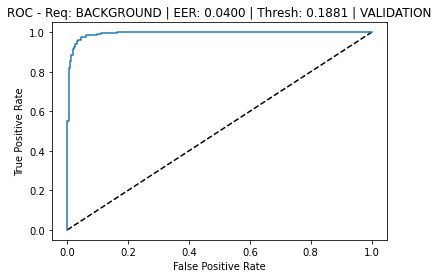

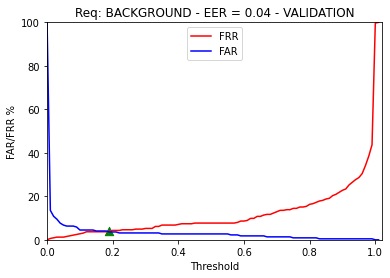

Requisite: BACKGROUND - EER_interp: 4.0% - Best Threshold: 0.18813820779323578
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.94      0.96      0.95       222
    COMPLIANT       0.97      0.96      0.97       325

     accuracy                           0.96       547
    macro avg       0.96      0.96      0.96       547
 weighted avg       0.96      0.96      0.96       547

Confusion matrix ----------------------------------------
FAR: 3.5999999999999996% | FRR: 4.0% | EER_mean: 3.8% | TP: 312 | TN: 214 | FP: 8 | FN: 13
Accuracy ------------------------------------------------
Model Accuracy: 96.16%
---------------------------------------------------------
Requisite: RED_EYES


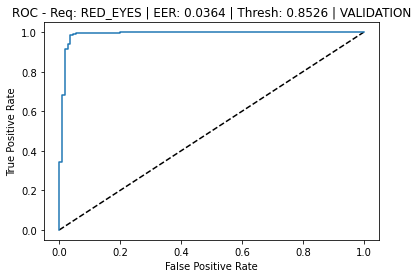

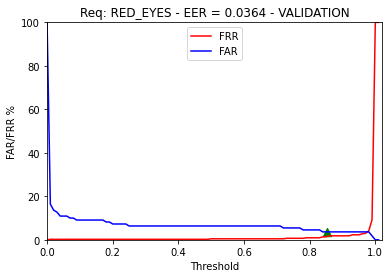

Requisite: RED_EYES - EER_interp: 3.64% - Best Threshold: 0.8526357412332499
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.95      0.96      0.95       110
    COMPLIANT       0.99      0.99      0.99       437

     accuracy                           0.98       547
    macro avg       0.97      0.97      0.97       547
 weighted avg       0.98      0.98      0.98       547

Confusion matrix ----------------------------------------
FAR: 3.64% | FRR: 1.37% | EER_mean: 2.5100000000000002% | TP: 431 | TN: 106 | FP: 4 | FN: 6
Accuracy ------------------------------------------------
Model Accuracy: 98.17%
---------------------------------------------------------
final_EER_mean: 11.24% | final_ACC: 90.19%


In [16]:
runner.set_model_evaluator_data_src(DataSource.VALIDATION)
runner.test_model()

## Test Split

Testing Trained Model
Predicting labels....
9/9 [==============================] - 18s 2s/step
Prediction finished!
Requisite: MOUTH


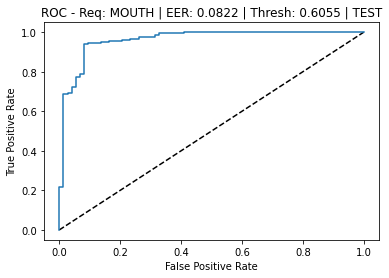

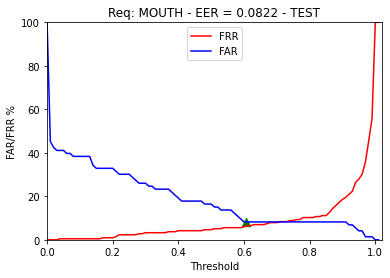

Requisite: MOUTH - EER_interp: 8.219999999999999% - Best Threshold: 0.6054924726484561
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.84      0.92      0.88        73
    COMPLIANT       0.97      0.94      0.96       215

     accuracy                           0.93       288
    macro avg       0.90      0.93      0.92       288
 weighted avg       0.94      0.93      0.93       288

Confusion matrix ----------------------------------------
FAR: 8.219999999999999% | FRR: 6.05% | EER_mean: 7.140000000000001% | TP: 202 | TN: 67 | FP: 6 | FN: 13
Accuracy ------------------------------------------------
Model Accuracy: 93.4%
---------------------------------------------------------
Requisite: ROTATION


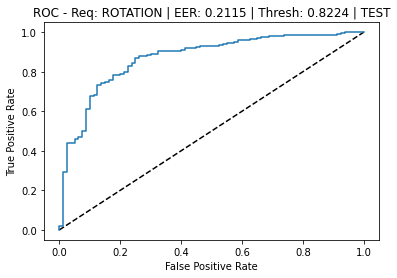

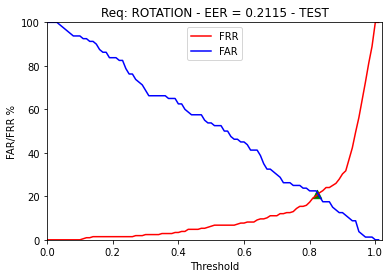

Requisite: ROTATION - EER_interp: 21.15% - Best Threshold: 0.8223768289272602
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.59      0.80      0.68        80
    COMPLIANT       0.91      0.79      0.85       208

     accuracy                           0.79       288
    macro avg       0.75      0.79      0.76       288
 weighted avg       0.82      0.79      0.80       288

Confusion matrix ----------------------------------------
FAR: 20.0% | FRR: 21.15% | EER_mean: 20.580000000000002% | TP: 164 | TN: 64 | FP: 16 | FN: 44
Accuracy ------------------------------------------------
Model Accuracy: 79.17%
---------------------------------------------------------
Requisite: L_AWAY


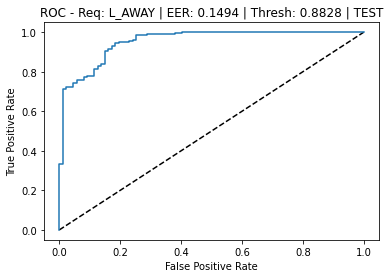

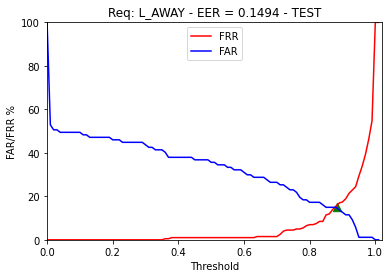

Requisite: L_AWAY - EER_interp: 14.940000000000001% - Best Threshold: 0.8828284740449914
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.70      0.85      0.77        87
    COMPLIANT       0.93      0.84      0.88       201

     accuracy                           0.84       288
    macro avg       0.81      0.85      0.82       288
 weighted avg       0.86      0.84      0.85       288

Confusion matrix ----------------------------------------
FAR: 14.940000000000001% | FRR: 15.920000000000002% | EER_mean: 15.43% | TP: 169 | TN: 74 | FP: 13 | FN: 32
Accuracy ------------------------------------------------
Model Accuracy: 84.38%
---------------------------------------------------------
Requisite: EYES_CLOSED


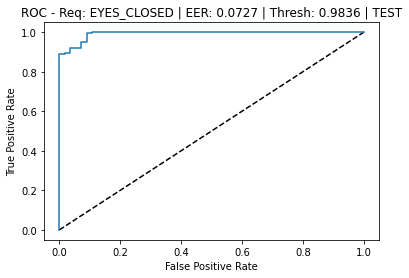

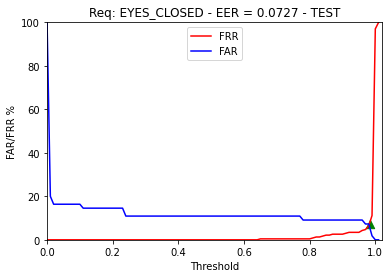

Requisite: EYES_CLOSED - EER_interp: 7.2700000000000005% - Best Threshold: 0.9835844039917025
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.74      0.93      0.82        55
    COMPLIANT       0.98      0.92      0.95       233

     accuracy                           0.92       288
    macro avg       0.86      0.93      0.89       288
 weighted avg       0.94      0.92      0.93       288

Confusion matrix ----------------------------------------
FAR: 7.2700000000000005% | FRR: 7.7299999999999995% | EER_mean: 7.5% | TP: 215 | TN: 51 | FP: 4 | FN: 18
Accuracy ------------------------------------------------
Model Accuracy: 92.36%
---------------------------------------------------------
Requisite: CLOSE


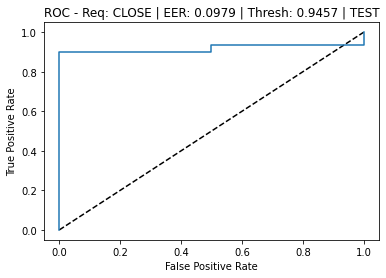

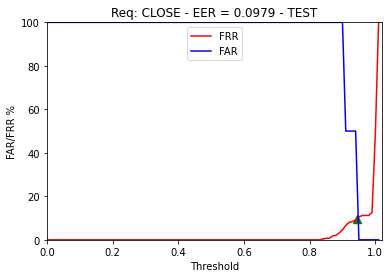

Requisite: CLOSE - EER_interp: 9.790000000000001% - Best Threshold: 0.9457255322616446
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.07      1.00      0.12         2
    COMPLIANT       1.00      0.90      0.95       286

     accuracy                           0.90       288
    macro avg       0.53      0.95      0.54       288
 weighted avg       0.99      0.90      0.94       288

Confusion matrix ----------------------------------------
FAR: 0.0% | FRR: 9.790000000000001% | EER_mean: 4.9% | TP: 258 | TN: 2 | FP: 0 | FN: 28
Accuracy ------------------------------------------------
Model Accuracy: 90.28%
---------------------------------------------------------
Requisite: HAT


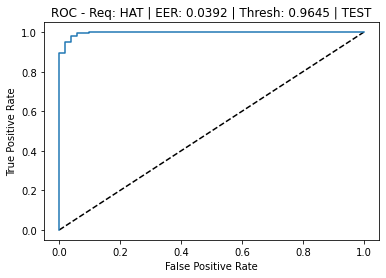

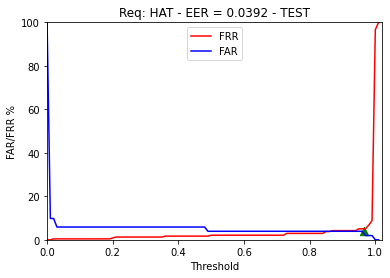

Requisite: HAT - EER_interp: 3.92% - Best Threshold: 0.9645028114321695
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.80      0.96      0.88        51
    COMPLIANT       0.99      0.95      0.97       237

     accuracy                           0.95       288
    macro avg       0.90      0.96      0.92       288
 weighted avg       0.96      0.95      0.95       288

Confusion matrix ----------------------------------------
FAR: 3.92% | FRR: 5.06% | EER_mean: 4.49% | TP: 225 | TN: 49 | FP: 2 | FN: 12
Accuracy ------------------------------------------------
Model Accuracy: 95.14%
---------------------------------------------------------
Requisite: DARK_GLASSES


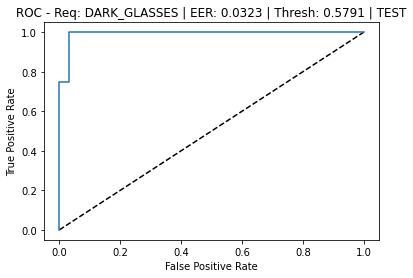

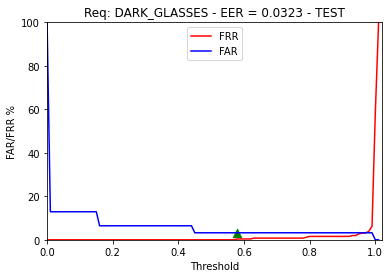

Requisite: DARK_GLASSES - EER_interp: 3.2300000000000004% - Best Threshold: 0.5791375637042708
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       1.00      0.97      0.98        31
    COMPLIANT       1.00      1.00      1.00       257

     accuracy                           1.00       288
    macro avg       1.00      0.98      0.99       288
 weighted avg       1.00      1.00      1.00       288

Confusion matrix ----------------------------------------
FAR: 3.2300000000000004% | FRR: 0.0% | EER_mean: 1.6199999999999999% | TP: 257 | TN: 30 | FP: 1 | FN: 0
Accuracy ------------------------------------------------
Model Accuracy: 99.65%
---------------------------------------------------------
Requisite: FRAMES_HEAVY


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


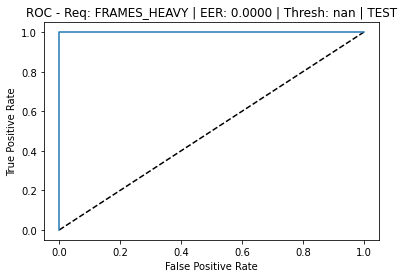

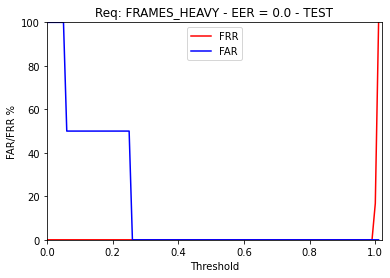

Requisite: FRAMES_HEAVY - EER_interp: 0.0% - Best Threshold: nan
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.00      0.00      0.00         2
    COMPLIANT       0.99      1.00      1.00       286

     accuracy                           0.99       288
    macro avg       0.50      0.50      0.50       288
 weighted avg       0.99      0.99      0.99       288

Confusion matrix ----------------------------------------
FAR: 100.0% | FRR: 0.0% | EER_mean: 50.0% | TP: 286 | TN: 0 | FP: 2 | FN: 0
Accuracy ------------------------------------------------
Model Accuracy: 99.31%
---------------------------------------------------------
Requisite: FRAME_EYES


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


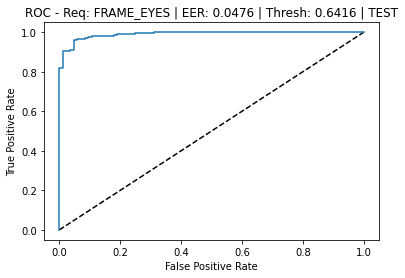

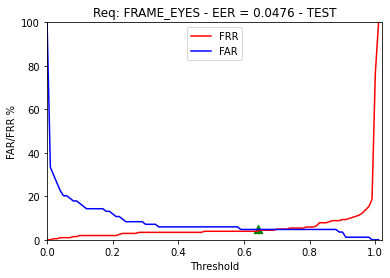

Requisite: FRAME_EYES - EER_interp: 4.760000000000001% - Best Threshold: 0.641604185102542
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.91      0.95      0.93        84
    COMPLIANT       0.98      0.96      0.97       204

     accuracy                           0.96       288
    macro avg       0.94      0.96      0.95       288
 weighted avg       0.96      0.96      0.96       288

Confusion matrix ----------------------------------------
FAR: 4.760000000000001% | FRR: 3.92% | EER_mean: 4.34% | TP: 196 | TN: 80 | FP: 4 | FN: 8
Accuracy ------------------------------------------------
Model Accuracy: 95.83%
---------------------------------------------------------
Requisite: FLASH_LENSES


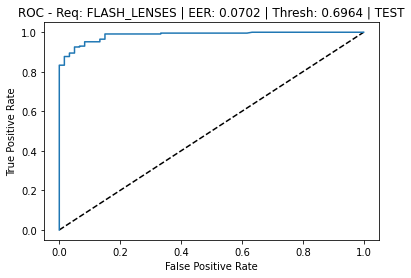

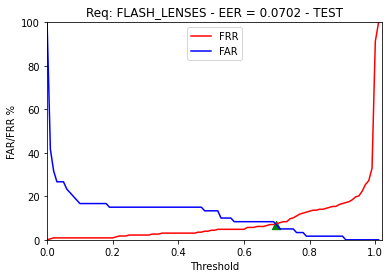

Requisite: FLASH_LENSES - EER_interp: 7.02% - Best Threshold: 0.6964117508185541
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.78      0.93      0.85        60
    COMPLIANT       0.98      0.93      0.95       228

     accuracy                           0.93       288
    macro avg       0.88      0.93      0.90       288
 weighted avg       0.94      0.93      0.93       288

Confusion matrix ----------------------------------------
FAR: 6.67% | FRR: 7.02% | EER_mean: 6.84% | TP: 212 | TN: 56 | FP: 4 | FN: 16
Accuracy ------------------------------------------------
Model Accuracy: 93.06%
---------------------------------------------------------
Requisite: VEIL


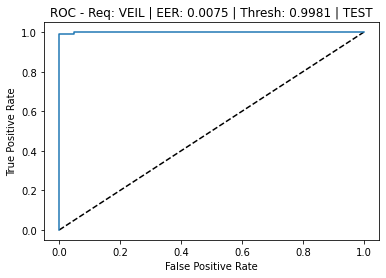

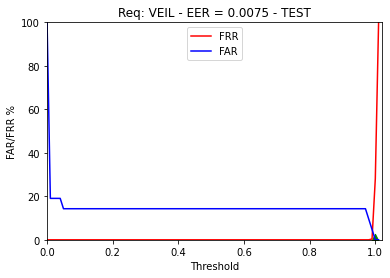

Requisite: VEIL - EER_interp: 0.75% - Best Threshold: 0.9980589713943139
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.91      1.00      0.95        21
    COMPLIANT       1.00      0.99      1.00       267

     accuracy                           0.99       288
    macro avg       0.96      1.00      0.98       288
 weighted avg       0.99      0.99      0.99       288

Confusion matrix ----------------------------------------
FAR: 0.0% | FRR: 0.75% | EER_mean: 0.38% | TP: 265 | TN: 21 | FP: 0 | FN: 2
Accuracy ------------------------------------------------
Model Accuracy: 99.31%
---------------------------------------------------------
Requisite: REFLECTION


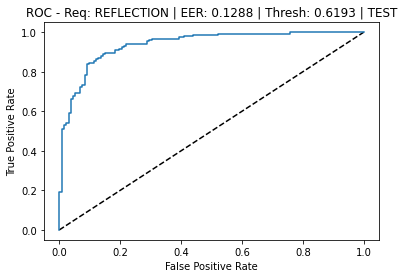

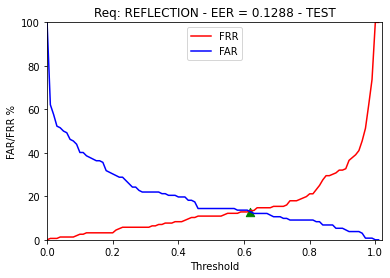

Requisite: REFLECTION - EER_interp: 12.879999999999999% - Best Threshold: 0.6193351149558652
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.85      0.87      0.86       132
    COMPLIANT       0.89      0.87      0.88       156

     accuracy                           0.87       288
    macro avg       0.87      0.87      0.87       288
 weighted avg       0.87      0.87      0.87       288

Confusion matrix ----------------------------------------
FAR: 12.879999999999999% | FRR: 12.82% | EER_mean: 12.85% | TP: 136 | TN: 115 | FP: 17 | FN: 20
Accuracy ------------------------------------------------
Model Accuracy: 87.15%
---------------------------------------------------------
Requisite: LIGHT


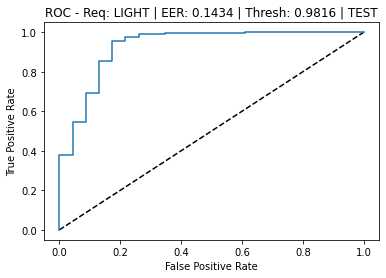

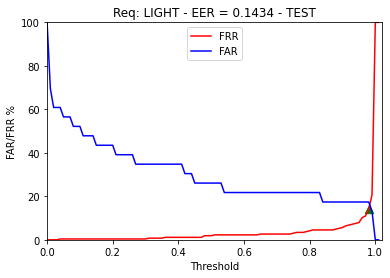

Requisite: LIGHT - EER_interp: 14.34% - Best Threshold: 0.9815893355405556
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.34      0.87      0.49        23
    COMPLIANT       0.99      0.86      0.92       265

     accuracy                           0.86       288
    macro avg       0.67      0.86      0.71       288
 weighted avg       0.94      0.86      0.88       288

Confusion matrix ----------------------------------------
FAR: 13.04% | FRR: 14.34% | EER_mean: 13.69% | TP: 227 | TN: 20 | FP: 3 | FN: 38
Accuracy ------------------------------------------------
Model Accuracy: 85.76%
---------------------------------------------------------
Requisite: SH_FACE


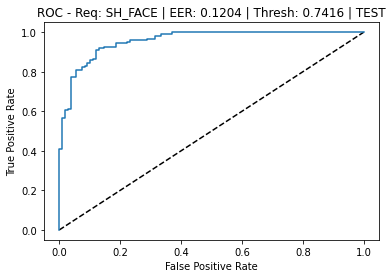

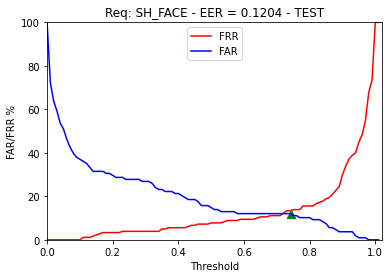

Requisite: SH_FACE - EER_interp: 12.04% - Best Threshold: 0.7416242361071503
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.80      0.88      0.84       108
    COMPLIANT       0.92      0.87      0.89       180

     accuracy                           0.87       288
    macro avg       0.86      0.87      0.87       288
 weighted avg       0.88      0.87      0.87       288

Confusion matrix ----------------------------------------
FAR: 12.04% | FRR: 13.33% | EER_mean: 12.68% | TP: 156 | TN: 95 | FP: 13 | FN: 24
Accuracy ------------------------------------------------
Model Accuracy: 87.15%
---------------------------------------------------------
Requisite: SH_HEAD


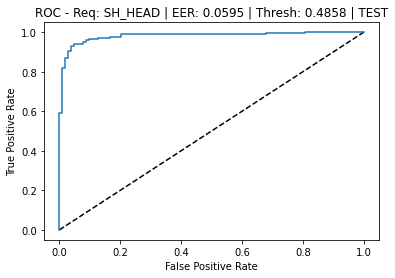

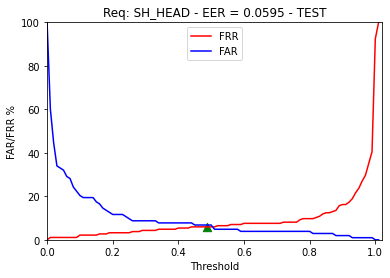

Requisite: SH_HEAD - EER_interp: 5.949999999999999% - Best Threshold: 0.48577609105152897
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.90      0.93      0.91       103
    COMPLIANT       0.96      0.94      0.95       185

     accuracy                           0.94       288
    macro avg       0.93      0.94      0.93       288
 weighted avg       0.94      0.94      0.94       288

Confusion matrix ----------------------------------------
FAR: 6.800000000000001% | FRR: 5.949999999999999% | EER_mean: 6.38% | TP: 174 | TN: 96 | FP: 7 | FN: 11
Accuracy ------------------------------------------------
Model Accuracy: 93.75%
---------------------------------------------------------
Requisite: BLURRED


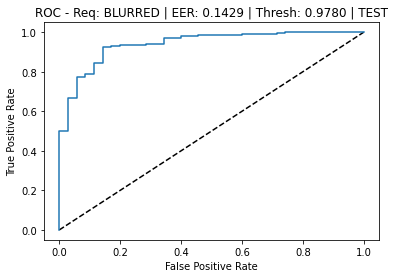

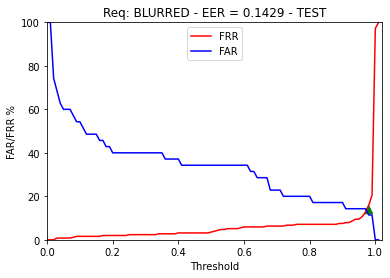

Requisite: BLURRED - EER_interp: 14.29% - Best Threshold: 0.9780135154725051
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.43      0.86      0.57        35
    COMPLIANT       0.98      0.84      0.90       253

     accuracy                           0.84       288
    macro avg       0.70      0.85      0.74       288
 weighted avg       0.91      0.84      0.86       288

Confusion matrix ----------------------------------------
FAR: 14.29% | FRR: 15.809999999999999% | EER_mean: 15.049999999999999% | TP: 213 | TN: 30 | FP: 5 | FN: 40
Accuracy ------------------------------------------------
Model Accuracy: 84.38%
---------------------------------------------------------
Requisite: SKIN_TONE


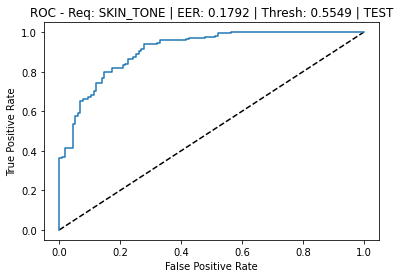

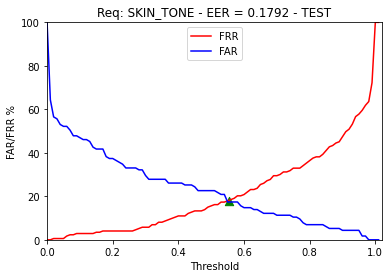

Requisite: SKIN_TONE - EER_interp: 17.919999999999998% - Best Threshold: 0.5549402659855827
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.75      0.83      0.79       115
    COMPLIANT       0.88      0.82      0.85       173

     accuracy                           0.82       288
    macro avg       0.82      0.82      0.82       288
 weighted avg       0.83      0.82      0.82       288

Confusion matrix ----------------------------------------
FAR: 17.39% | FRR: 17.919999999999998% | EER_mean: 17.65% | TP: 142 | TN: 95 | FP: 20 | FN: 31
Accuracy ------------------------------------------------
Model Accuracy: 82.28999999999999%
---------------------------------------------------------
Requisite: WASHED_OUT


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


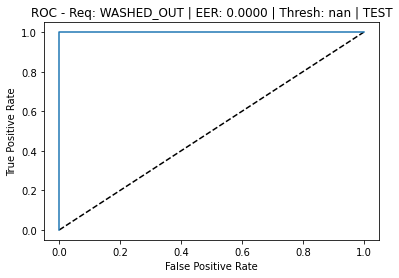

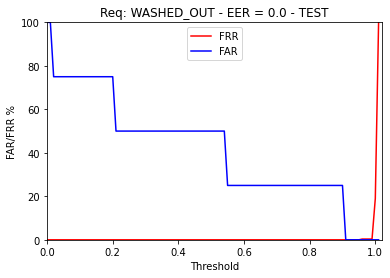

Requisite: WASHED_OUT - EER_interp: 0.0% - Best Threshold: nan
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.00      0.00      0.00         4
    COMPLIANT       0.99      1.00      0.99       284

     accuracy                           0.99       288
    macro avg       0.49      0.50      0.50       288
 weighted avg       0.97      0.99      0.98       288

Confusion matrix ----------------------------------------
FAR: 100.0% | FRR: 0.0% | EER_mean: 50.0% | TP: 284 | TN: 0 | FP: 4 | FN: 0
Accuracy ------------------------------------------------
Model Accuracy: 98.61%
---------------------------------------------------------
Requisite: PIXELATION


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


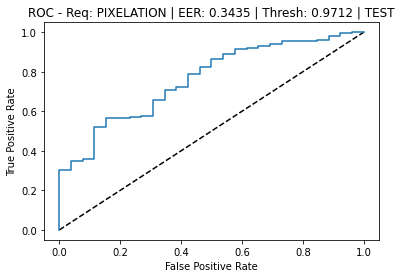

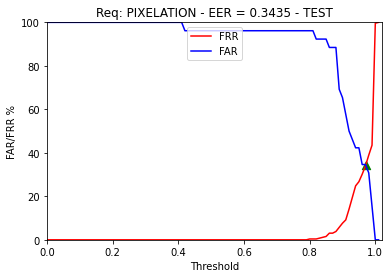

Requisite: PIXELATION - EER_interp: 34.35% - Best Threshold: 0.9711585322409185
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.17      0.69      0.27        26
    COMPLIANT       0.96      0.66      0.78       262

     accuracy                           0.66       288
    macro avg       0.56      0.67      0.52       288
 weighted avg       0.88      0.66      0.73       288

Confusion matrix ----------------------------------------
FAR: 30.769999999999996% | FRR: 34.35% | EER_mean: 32.56% | TP: 172 | TN: 18 | FP: 8 | FN: 90
Accuracy ------------------------------------------------
Model Accuracy: 65.97%
---------------------------------------------------------
Requisite: HAIR_EYES


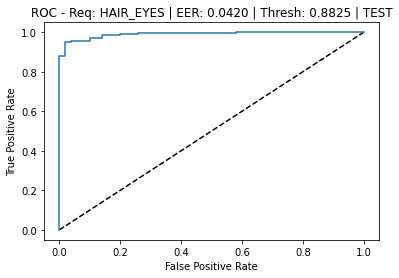

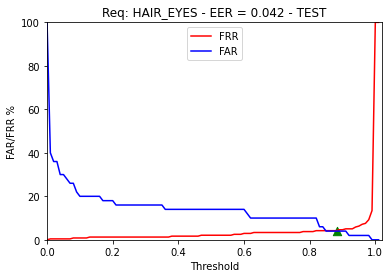

Requisite: HAIR_EYES - EER_interp: 4.2% - Best Threshold: 0.8825349968020655
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.83      0.96      0.89        50
    COMPLIANT       0.99      0.96      0.97       238

     accuracy                           0.96       288
    macro avg       0.91      0.96      0.93       288
 weighted avg       0.96      0.96      0.96       288

Confusion matrix ----------------------------------------
FAR: 4.0% | FRR: 4.2% | EER_mean: 4.1000000000000005% | TP: 228 | TN: 48 | FP: 2 | FN: 10
Accuracy ------------------------------------------------
Model Accuracy: 95.83%
---------------------------------------------------------
Requisite: BACKGROUND


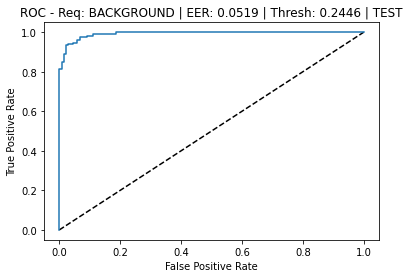

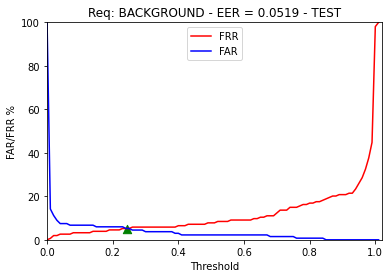

Requisite: BACKGROUND - EER_interp: 5.19% - Best Threshold: 0.24464321891212168
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.94      0.95      0.94       134
    COMPLIANT       0.95      0.95      0.95       154

     accuracy                           0.95       288
    macro avg       0.95      0.95      0.95       288
 weighted avg       0.95      0.95      0.95       288

Confusion matrix ----------------------------------------
FAR: 5.220000000000001% | FRR: 5.19% | EER_mean: 5.2% | TP: 146 | TN: 127 | FP: 7 | FN: 8
Accuracy ------------------------------------------------
Model Accuracy: 94.78999999999999%
---------------------------------------------------------
Requisite: RED_EYES


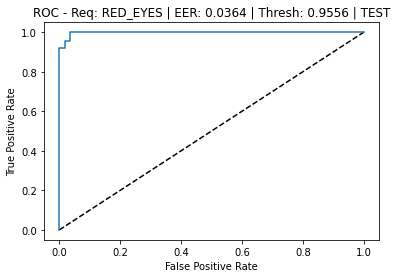

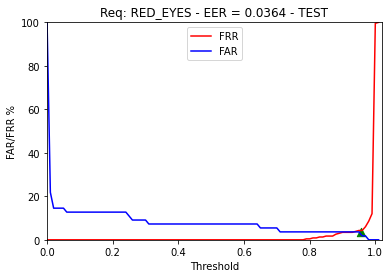

Requisite: RED_EYES - EER_interp: 3.64% - Best Threshold: 0.9556478261950516
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.84      0.96      0.90        55
    COMPLIANT       0.99      0.96      0.97       233

     accuracy                           0.96       288
    macro avg       0.92      0.96      0.94       288
 weighted avg       0.96      0.96      0.96       288

Confusion matrix ----------------------------------------
FAR: 3.64% | FRR: 4.29% | EER_mean: 3.9699999999999998% | TP: 223 | TN: 53 | FP: 2 | FN: 10
Accuracy ------------------------------------------------
Model Accuracy: 95.83%
---------------------------------------------------------
final_EER_mean: 13.52% | final_ACC: 90.61%


In [17]:
runner.set_model_evaluator_data_src(DataSource.TEST)
runner.test_model()

# Visualize Model Classification

# Finishing Experiment Manager

In [18]:
runner.finish_experiment()

-------------------- finish experiment -------------------
Finishing Neptune


Error occurred during asynchronous operation processing: Value of float attribute cannot be malformed.
Error occurred during asynchronous operation processing: Value of float attribute cannot be malformed.
Error occurred during asynchronous operation processing: Value of float attribute cannot be malformed.


# Testing Network Modification